## BOLFI

This notebook demonstrates how [BoTorch](https://botorch.org/) models and acquisition functions can be used in BOLFI with `BoTorchModel` and `BoTorchAcquisition` wrappers. For introduction to BOLFI, please read the [BOLFI tutorial](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html).

In [1]:
import os

In [2]:
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import elfi
from botorch_wrapper import BoTorchModel, BoTorchAcquisition

### Basic example

Here we take the posterior estimation task considered in BOLFI tutorial but substitute the default model and acquisition method with `BoTorchModel` and `BoTorchAcquisition` instances.

- Task

In [4]:
from elfi.examples import ma2

In [5]:
seed = 1
m = ma2.get_model(seed_obs=seed)

We use optimisation to find simulator parameters that minimise the log-compressed distance:

In [6]:
log_d = elfi.Operation(np.log, m['d'])

The simulator model has two parameters:

In [7]:
m.parameter_names

['t1', 't2']

We set bounds on each parameter to define the search area considered in optimisation:

In [8]:
bounds = {'t1':(-2, 2), 't2':(-1, 1)}

- Model

`BoTorchModel` constructor needs parameter names and bounds as input. We can also provide `model_options` which are passed on to the model class constructor documented [here](https://botorch.org/api/models.html#botorch.models.gp_regression.SingleTaskGP). These include `covar_module` and `mean_module` that determine the model kernel and mean function. Here we use the default options.

In [9]:
model = BoTorchModel(m.parameter_names, bounds, seed=seed)

`BoTorchModel` instances can be used with the acquisition methods available in ELFI, but optimisation is faster when the model is combined with a `BoTorchAcquisition` method.

- Acquisition method

`BoTorchAcquisition` constructor needs an acquisition class and acquisition options as input. The options are passed on to the selected acquisition class constructor. Here we use the upper confidence bound acquisition rule:

In [10]:
from botorch.acquisition.analytic import UpperConfidenceBound
acq_class = UpperConfidenceBound

The acquisition options depend on the selected class. The upper confidence bound used in this example needs parameter `beta` and accepts option `maximize`. We use the option to convert upper confidence bound maximisation into lower confidence bound minimisation:

In [11]:
acq_options = {'beta': 20, 'maximize': False}

`BoTorchAcquisition` constructor also accepts `optim_params` which is passed on to the optimisation method documented [here](https://botorch.org/api/optim.html#botorch.optim.optimize.optimize_acqf). The optimisation parameters include, for example, `num_restarts` which is comparable to the `n_inits` option in the acquisition functions in ELFI.

In [12]:
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

- BOLFI

BOLFI options include `initial_evidence` and `update_interval` which determine when we start to use the acquisition method and how often we optimise the model fit to available data.

In [13]:
options = {'initial_evidence': 20, 'update_interval': 10, 'seed': seed}

Here we use BOLFI with the model and acquisition method that were created above.

In [14]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)

Run optimisation:

In [15]:
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 10.8 s, sys: 408 ms, total: 11.2 s
Wall time: 13.5 s


We can visualise the data collected in optimisation and see what has been learned about the dependencies between the model parameters and `log_d`:

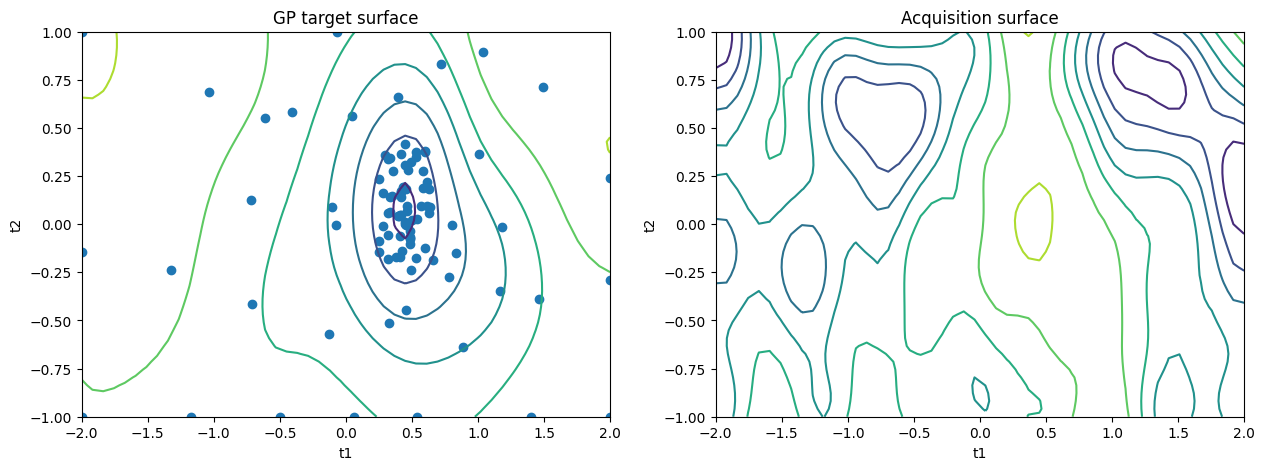

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

To conclude posterior estimation, we can use the fitted model to sample parameter combinations from the estimated approximate posterior. This can be slow.

In [17]:
%time res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
t1 954.9269925863605 1.0022884157166652
t2 1194.527658733575 1.0033016728350312
CPU times: user 4min 46s, sys: 3.84 s, total: 4min 50s
Wall time: 5min 8s


In [18]:
res

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -1.68
Parameter                Mean               2.5%              97.5%
t1:                     0.398             -0.273              0.859
t2:                     0.109             -0.484              0.764


This concludes the basic example. You can read more about the posterior sample in the [BOLFI tutorial](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html#sampling). The next sections demonstrate some model and acquisition options that were not discussed above.

### Model options

The default model used in the above example is an exact Gaussian process model constructed with the default options documented [here](https://botorch.org/api/models.html#botorch.models.gp_regression.SingleTaskGP). The model can be customised with `model_options` that are passed on the constructor. This is expected to cover most use cases, but it is also possible to initialise `BoTorchModel` with custom `model_constructor` and `model_optimizer` to substitute the defaults.

The default options work best when the input parameters take values between 0 and 1 and the discrepancies have zero mean and unit variance. When this is not the case, we can use `model_options` to either normalise the data or pass on modules that better fit the data. Here we use normalisation.

In [19]:
import torch
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

We create an input transformation based on the search area bounds.

In [20]:
torch_bounds = torch.tensor(np.transpose([bounds[name] for name in m.parameter_names]))
input_transform = Normalize(len(m.parameter_names), bounds=torch_bounds)

The transformations are passed on to the model constructor as model options.

In [21]:
model_options = {'input_transform': input_transform, 'outcome_transform': Standardize(1)}
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)

Run optimisation:

In [22]:
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 9.38 s, sys: 178 ms, total: 9.56 s
Wall time: 10.7 s


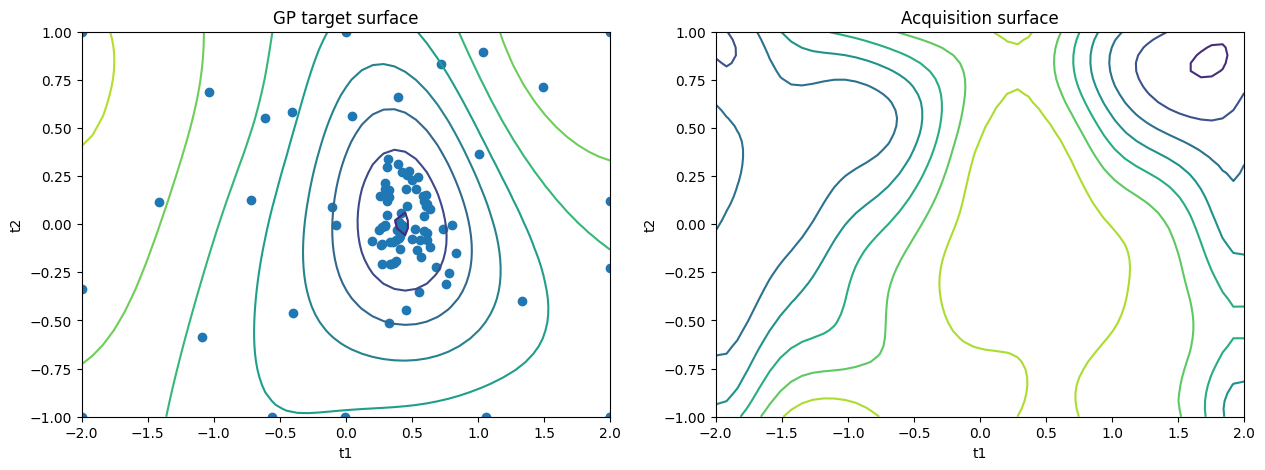

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Acquisition options

Some BoTorch acquisition classes take inputs that cannot be determined at the time when we initialise the `BoTorchAcquisition` wrapper. Examples include acquisition classes that need the current best observation or predicted minimum as input.

`BoTorchAcquisition` wrapper handles adaptive input parameters as follows. The parameters are represented in acquisition options as functions that take a `BoTorchModel` instance as input and calculate the parameter value based on the current model state. To demonstrate, let us use an adaptive `beta` in the upper confidence bound acquisition rule. Here we update the parameter value based on the current evidence count as proposed in [Srinivas et al (2010)](https://icml.cc/Conferences/2010/papers/422.pdf) (Theorem 1).

In [24]:
def beta_n(model):
    delta = 0.1
    return np.log(model.input_dim * np.power(model.n_evidence, 2) * np.power(np.pi, 2) / (6 * delta))

We use the function to substitute the fixed `beta` in `acq_options`:

In [25]:
acq_options = {'beta': beta_n, 'maximize': False}

Create a new model and acquisition method instance:

In [26]:
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

Run optimisation:

In [27]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 9.96 s, sys: 179 ms, total: 10.1 s
Wall time: 11.4 s


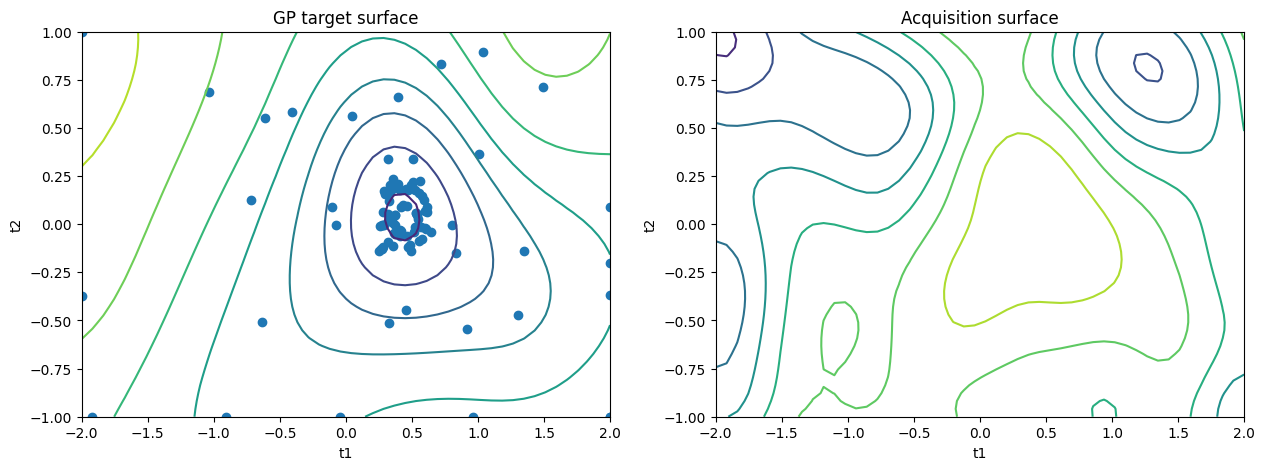

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Batch acquisitions

The acquisition method used in the above examples does not work with `batch_size` > 1. To make batch acquisitions based on the upper confidence bound rule, we must use:

In [29]:
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
acq_class = qUpperConfidenceBound
acq_options = {'beta': 20}

The reason we did not use this variant in the basic example is that the acquisition class does not have the `maximize` option that is used to support minimisation. Since this is the case with some acquisition classes, the model wrapper has an option `negate` that can be used instead.

In [30]:
model = BoTorchModel(m.parameter_names, bounds, negate=True, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

Run optimisation:

In [31]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, batch_size=4, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 7.32 s, sys: 190 ms, total: 7.51 s
Wall time: 7.77 s


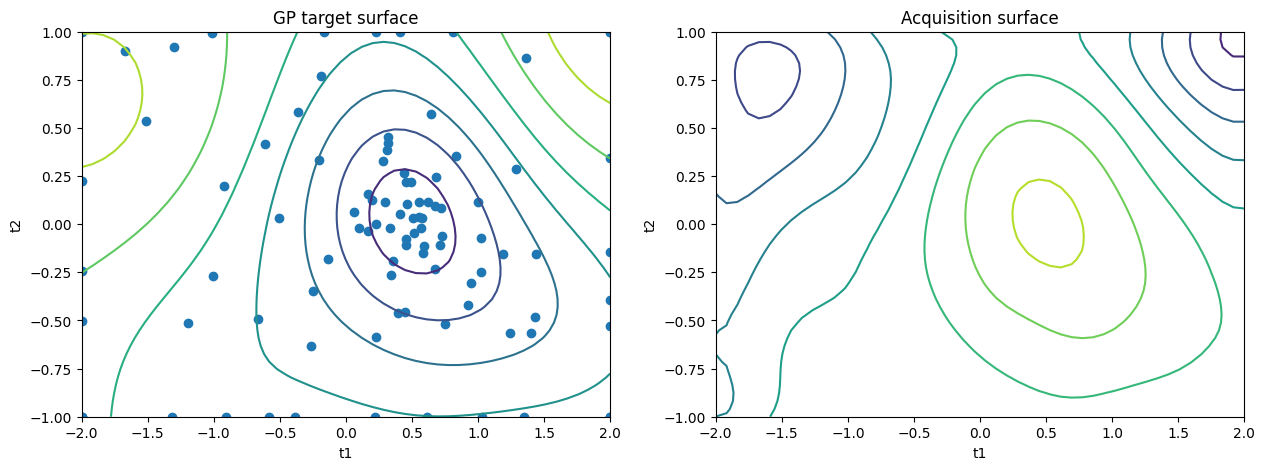

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Constrained optimisation

The parameters considered in this notebook are associated with a prior distribution that is non-zero when $t_1 + t_2 > -1$ and $t_2 - t_1 > -1$.
This means that we are not interested in simulations outside this area and could constrain the search area considered in optimisation.

In [33]:
constraints = [(torch.tensor([0, 1]), torch.tensor([1, 1], dtype=torch.double), -1), (torch.tensor([0, 1]), torch.tensor([-1, 1], dtype=torch.double), -1)]

The constraints are introduced into the acquisition method as optimisation parameters.

In [34]:
optim_params = {'num_restarts': 5, 'inequality_constraints': constraints}

Create a new model and acquisition method instance:

In [35]:
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, UpperConfidenceBound, {'beta': 20, 'maximize': False}, optim_params=optim_params)

Run optimisation:

In [36]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 2min 22s, sys: 1.91 s, total: 2min 24s
Wall time: 2min 28s


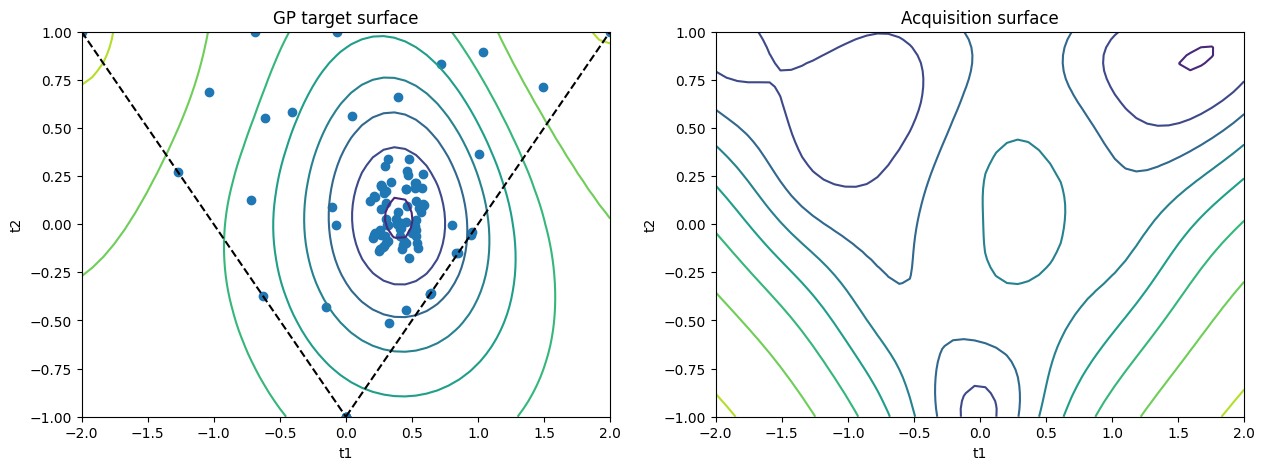

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();
ax[0].plot(np.linspace(-2,2), (constraints[0][1][0]*np.linspace(-2,2)+constraints[0][2])/constraints[0][1][1], color='k', linestyle='--')
ax[0].plot(np.linspace(-2,2), (constraints[1][1][0]*np.linspace(-2,2)+constraints[1][2])/constraints[1][1][1], color='k', linestyle='--');